In [12]:
# %cd ~/PycharmProjects/muse
%cd /iliad/u/belkhale/muse
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np


def sweep_from_arr(arr):
    s = "[[[ "
    for a in arr:
        s = s + str(a) + " "
    s = s + "]]]"
    return s


/iliad/u/belkhale/muse


In [13]:
# show the state diversity needed?

def plot_2d_state_heatmap(data, t1=None, t2=None, xy_key='robot0_eef_pos', done_key='done', n_bins=30, vmax=200, num_rollouts=None, log=True, ax=None):
    xy = data[xy_key]

    splits = data[done_key].nonzero()[0][:-1] + 1
    episodes = np.split(xy, splits, axis=0)
    if num_rollouts is not None:
        episodes = episodes[:num_rollouts]

    if t1 is not None:
        if t2 is None:
            episodes = [ep[t1:] for ep in episodes]
        else:
            episodes = [ep[t1:t2] for ep in episodes]

    partial_xy = np.concatenate(episodes)
    x, y = partial_xy[..., 0], partial_xy[..., 1]
    
    if log:
#         norm = colors.LogNorm(vmin=1, vmax=vmax+1)
        norm = colors.FuncNorm((lambda v: np.log(v + 1) / np.log(vmax + 1), lambda v: np.exp(v*np.log(vmax+1))),
                               vmin=0, vmax=vmax)
    else:
        norm = None
    
    if ax is not None:
        return ax.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)[-1]
    else:
        plt.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)
        plt.colorbar()
        plt.show()

Loading human_square_30k.npz


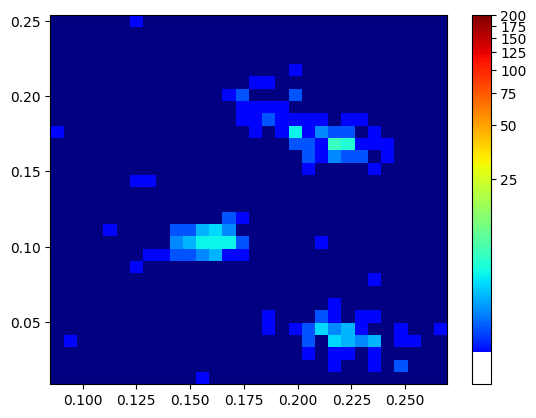

In [14]:
name = 'human_square_30k.npz'
file = f'data/hvs/{name}'
print("Loading", name)
plot_2d_state_heatmap(dict(np.load(file, allow_pickle=True)), t1=-1)

# LEARNED

In [15]:
def compute_success_rate(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    if max_steps is not None:
        # only look at max reward over first "max_steps" steps
        rew_chunks = [r[:max_steps] for r in rew_chunks]
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_return = np.array([np.max(rews) for rews in rew_chunks])
    return np.mean(each_return)
    
def compute_traj_len(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.mean(each_len)

def compute_traj_std(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.std(each_len)
    

In [22]:
# extract success rates for each set of rollouts
import os
from configs.utils import hr_name

def print_metric(noise_type='s', prefix="best_", num_rollouts=100, dset_override=None, metric_fn=compute_success_rate):

    s_noises = [0.05, 0.1, 0.2]
    typed_noises = {
        'h': [0],  # human has no noise
        'p': [0, 0.005, 0.01, 0.02],
        's': s_noises,
    }[noise_type]

    dset_suffs = ['', '-first100', '-first50']
    if dset_override is not None:
        dset_suffs = [dset_override]
    
    batch_sizes = [256 for _ in dset_suffs]

    for batch_size, suff in zip(batch_sizes, dset_suffs):
        success = np.empty((len(typed_noises), len(s_noises)), dtype=np.float32)
        for i, n in enumerate(typed_noises):
            hr_s_sweep = sweep_from_arr(s_noises)
            # special case for zero noise
            if n == 0:
                noise = ""
            else:
                noise = f"_l{noise_type}n{hr_name(n)}"

            save_names = [f"{prefix}eval{num_rollouts}_lsn{hr_name(inner_s)}.npz" for inner_s in s_noises]
            hr_names = sweep_from_arr(save_names)

            # single dataset overrides the list of suffixes.
            if dset_override is not None:
                dset = suff
            else:
                assert noise_type != 'h', "Human dataset requires dset override!"
            dset = f"scripted_rm{noise}_square_200ep{suff}"

            exp_name = f'experiments/hvs/velact_b{batch_size}_h10_{dset}_bc-l2_mlp400-d2'
            for j, file in enumerate(save_names):
                path = f"{exp_name}/{file}"
                assert os.path.exists(path), path
                success[i, j] = metric_fn(path, num_rollouts)

        print(f"Suff='{suff}'...")
        print(success)
        print('------------------------------')


In [23]:
print('SYSTEM NOISE')
print_metric(noise_type='s', prefix='best_')
print('\nPOLICY NOISE')
print_metric(noise_type='p', prefix='best_')

SYSTEM NOISE
Suff=''...
[[0.61 0.59 0.31]
 [0.76 0.82 0.73]
 [0.62 0.7  0.85]]
------------------------------
Suff='-first100'...
[[0.73 0.62 0.45]
 [0.73 0.79 0.62]
 [0.73 0.84 0.79]]
------------------------------
Suff='-first50'...
[[0.63 0.58 0.31]
 [0.65 0.69 0.73]
 [0.55 0.79 0.87]]
------------------------------

POLICY NOISE
Suff=''...
[[0.3  0.29 0.07]
 [0.65 0.64 0.31]
 [0.87 0.81 0.52]
 [0.8  0.81 0.8 ]]
------------------------------
Suff='-first100'...
[[0.26 0.23 0.09]
 [0.79 0.65 0.4 ]
 [0.93 0.94 0.76]
 [0.61 0.59 0.47]]
------------------------------
Suff='-first50'...
[[0.19 0.17 0.09]
 [0.69 0.6  0.32]
 [0.85 0.9  0.8 ]
 [0.66 0.78 0.83]]
------------------------------


In [27]:
# success rate for scripted policy, policy noise datasets (100 step max)
fs = [
    'scripted_rm_lsn0_05_square_200ep.npz',
    'scripted_rm_lsn0_1_square_200ep.npz',
    'scripted_rm_lsn0_2_square_200ep.npz',
    'scripted_rm_square_200ep.npz',
    'scripted_rm_lpn0_005_square_200ep.npz',
    'scripted_rm_lpn0_01_square_200ep.npz',
    'scripted_rm_lpn0_02_square_200ep.npz',
]
for f in fs:
    print(f, compute_success_rate(f'data/hvs/{f}', 200))

scripted_rm_lsn0_05_square_200ep.npz 1.0
scripted_rm_lsn0_1_square_200ep.npz 1.0
scripted_rm_lsn0_2_square_200ep.npz 1.0
scripted_rm_square_200ep.npz 1.0
scripted_rm_lpn0_005_square_200ep.npz 1.0
scripted_rm_lpn0_01_square_200ep.npz 1.0
scripted_rm_lpn0_02_square_200ep.npz 1.0


# TRAJECTORY LENGTH

In [30]:
# MEAN
for f in fs[:3]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 234.545
scripted_rm_lsn0_1_square_200ep.npz 236.62
scripted_rm_lsn0_2_square_200ep.npz 253.165
#################
scripted_rm_lpn0_005_square_200ep.npz 234.9
scripted_rm_lpn0_01_square_200ep.npz 251.43
scripted_rm_lpn0_02_square_200ep.npz 290.555


In [31]:
# STD
for f in fs[:3]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 22.79118195706401
scripted_rm_lsn0_1_square_200ep.npz 24.738746936738732
scripted_rm_lsn0_2_square_200ep.npz 25.70306936924071
#################
scripted_rm_lpn0_005_square_200ep.npz 21.95267637441959
scripted_rm_lpn0_01_square_200ep.npz 28.25004601766164
scripted_rm_lpn0_02_square_200ep.npz 37.41078688025688
